<a href="https://colab.research.google.com/github/ronaldosilvak/analises_exploratorias/blob/main/Notebook_Meteora_SQLAlchemy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Alt text: Slogan da Meteora.](https://i.imgur.com/VDYh2G1.png)

# 1. Estruturando a tabela

**Meteora** é uma loja que vende roupas e acessórios de diversas marcas por todos os estados do Brasil, para entender suas bases de dados e exibir informações relevantes com o objetivo de auxiliar suas tomadas de decisão.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text

**Sobre as tabelas**

* itens_pedidos: tabela que informa sobre o que foi vendido, vai ter informação o preço, quantidade, para onde vai ser enviado e o frete do pedido
* pedidos: vai falar sobre a venda feita, tendo informação sobre os vendedores, preço do pedido e a data da venda
* produtos: informa características dos produtos que são comercializados na loja
* vendedores: informa o nome dos vendedores.

In [2]:
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [3]:
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produto)
vendedores = pd.read_csv(url_vendedores)

In [4]:
engine = create_engine('sqlite:///:memory:')

In [5]:
produtos.to_sql('produtos', engine, index=False)

205

In [6]:
itens_pedidos.to_sql('itens_pedidos', engine, index=False)
pedidos.to_sql('pedidos', engine, index=False)
vendedores.to_sql('vendedores', engine, index=False)

5

In [7]:
inspector = inspect(engine)
print(inspector.get_table_names())

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']


# 2. Primeiras consultas

Vamos entender a característica do produto que é comercializadora na Meteora, analisando a **condição** dos produtos vendidos.

In [8]:
query = 'SELECT CONDICAO FROM PRODUTOS'

In [9]:
with engine.connect() as conexao:
  consulta = conexao.execute(text(query))
  dados = consulta.fetchall()
pd.DataFrame(dados, columns=consulta.keys())

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [10]:
def sql_df(query):
  with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
  return pd.DataFrame(dados, columns=consulta.keys())

In [11]:
query = '''SELECT CONDICAO, COUNT(*) AS 'Quantidade'
FROM PRODUTOS
GROUP BY CONDICAO
ORDER BY COUNT(*) DESC'''

df_produtos = sql_df(query)
df_produtos

,Condicao,Quantidade
0,Usado,176
1,Novo com etiqueta,22
2,Novo sem etiqueta,7


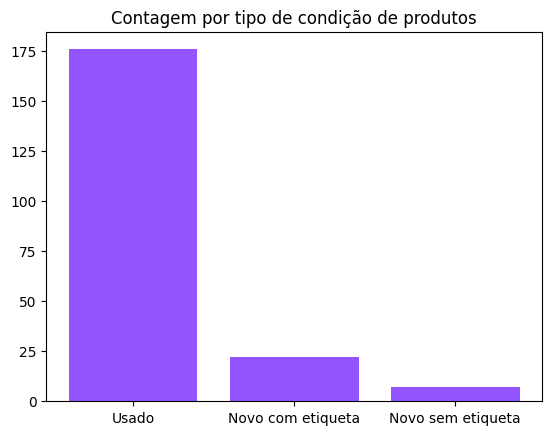

In [12]:

plt.bar(df_produtos['Condicao'], df_produtos['Quantidade'], color='#9353FF')
plt.title('Contagem por tipo de condição de produtos')
plt.show()

Agora precisamos ranquear os produtos que mais foram pedidos por **quantidade** para entender a necessidade de um estoque de produtos na loja.

In [13]:
sql_df('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [14]:
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)


,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [15]:
query = '''SELECT p.produto as Produto, SUM(ip.quantidade) as Quantidade
FROM ITENS_PEDIDOS ip
JOIN PRODUTOS p ON IP.produto_id = P.produto_id
GROUP BY p.produto
ORDER BY Quantidade ASC
'''

df_prod_quant = sql_df(query)
df_prod_quant

,Produto,Quantidade
0,Vestido Malha Estampa,318
1,Blusa Listrada Malha,322
2,Blusa Malha Azul,325
3,Blusa Babados Off-white,337
4,Blusa Cinza,341
...,...,...
196,Saia Midi Cinto,549
197,Calca Alfaiataria Preta,750
198,Saia Pregas Preta,751
199,Calca Jeans Costuras,755


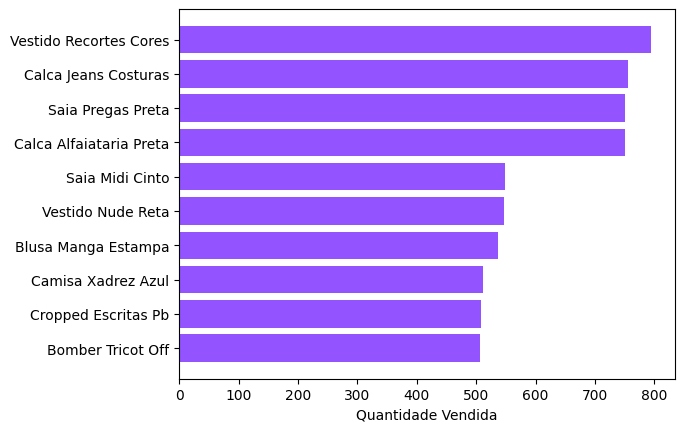

In [16]:
plt.barh(df_prod_quant['Produto'][-10:], df_prod_quant['Quantidade'][-10:], color='#9353FF')
plt.xlabel('Quantidade Vendida')
plt.show()

**DESAFIO 01**

Vamos aos desafios dessa aula, o primeiro é exibir os 10 produtos mais vendidos durante o ano de 2019, que podem ser representados em uma tabela. Já o segundo será publicar a distribuição através dos meses da receita obtida em vendas no ano de 2021. Busque mostrar essa distribuição colocando o mês e sua receita correspondente na visualização.

In [17]:
query = '''SELECT PRODUTOS.PRODUTO, COUNT(PEDIDOS.PEDIDO_ID) AS TOTAL_PEDIDOS
FROM PEDIDOS, PRODUTOS
WHERE strftime('%Y', data_compra) = '2019' AND PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY TOTAL_PEDIDOS DESC
LIMIT 10;
'''
sql_df(query)


,produto,TOTAL_PEDIDOS
0,Vestido Recortes Cores,85
1,Calca Jeans Costuras,81
2,Saia Pregas Preta,73
3,Calca Alfaiataria Preta,66
4,Camisa Xadrez Azul,60
5,Bomber Tricot Off,56
6,Shorts Bordado Branco,55
7,Blusa Manga Estampa,54
8,Saia Midi Cinto,53
9,Saia Evase Cinza,53


In [18]:
query = '''SELECT strftime('%m', data_compra) as mes, SUM(total) as receita
FROM PEDIDOS
WHERE strftime('%Y', data_compra) = '2021'
GROUP BY mes
ORDER BY receita ASC'''

df_2021 = sql_df(query)
df_2021


,mes,receita
0,03,51525
1,02,1140729
2,01,2097109


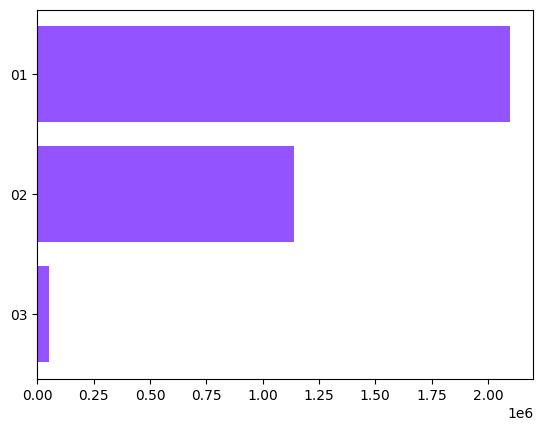

In [19]:
plt.barh(df_2021['mes'][-3:], df_2021['receita'][-3:], color='#9353FF')
plt.show()

**DESAFIO 02**

A primeira informação é listar as marcas vendidas em São Paulo por quantidade de pedidos, que podem ser representadas em uma tabela. Já a segunda informação é publicar os produtos que são mais vendidos na época de Natal no Brasil todo. Essa última informação é aplicada a todos os estados porque somente o estado de São Paulo pode não trazer uma quantidade relevante de informações.

In [20]:
query_sp = '''SELECT p.marca, COUNT(*) as pedidos
FROM PRODUTOS p
JOIN ITENS_PEDIDOS ip ON ip.PRODUTO_ID = p.PRODUTO_ID
WHERE ip.Estado = 'BR-SP'
GROUP BY p.MARCA
ORDER BY COUNT(ip.PRODUTO_ID) DESC;
'''

df_sp = sql_df(query_sp)
df_sp

,marca,pedidos
0,Zara,100
1,Mixed,58
2,Animale,44
3,Le Lis Blanc,26
4,Banana Republic,18
...,...,...
111,Topshop,1
112,Morena Rosa,1
113,Erre Erre,1
114,Bobô,1


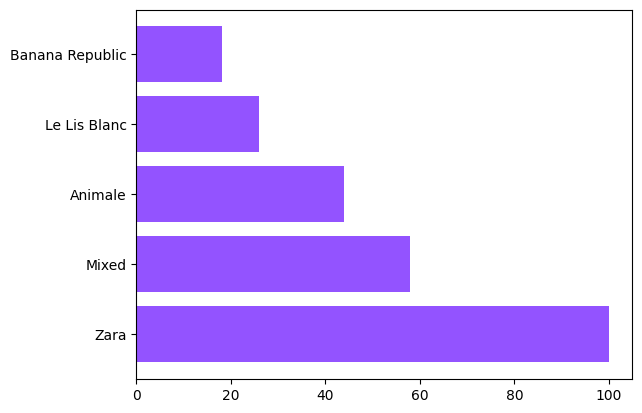

In [21]:
plt.barh(df_sp['marca'][:5], df_sp['pedidos'][:5], color='#9353FF')
plt.show()

**Marcas mais vendidas**

In [22]:
query = '''SELECT p.marca, COUNT(*) as pedidos
FROM PRODUTOS p, ITENS_PEDIDOS ip
WHERE p.produto_id = ip.produto_id
GROUP BY p.marca
ORDER BY COUNT(*) ASC'''

df_marcas = sql_df(query)
df_marcas


,marca,pedidos
0,Talie Nk,94
1,Track & Field,96
2,Ateliê de Calças,99
3,Bottega Veneta,101
4,Bcbgmaxzria,103
...,...,...
112,Banana Republic,584
113,Le Lis Blanc,715
114,Animale,1128
115,Mixed,1673


**OUTRA QUERY POSSÍVEL!**

In [23]:
outra_query_possivel = '''SELECT p.marca, COUNT(*) as pedidos
FROM PRODUTOS p, ITENS_PEDIDOS ip
JOIN p.produto_id ON ip.produto_id = p.produto_id
GROUP BY p.marca
ORDER BY COUNT(*) ASC
'''


df_marcas = sql_df(query)
df_marcas

,marca,pedidos
0,Talie Nk,94
1,Track & Field,96
2,Ateliê de Calças,99
3,Bottega Veneta,101
4,Bcbgmaxzria,103
...,...,...
112,Banana Republic,584
113,Le Lis Blanc,715
114,Animale,1128
115,Mixed,1673


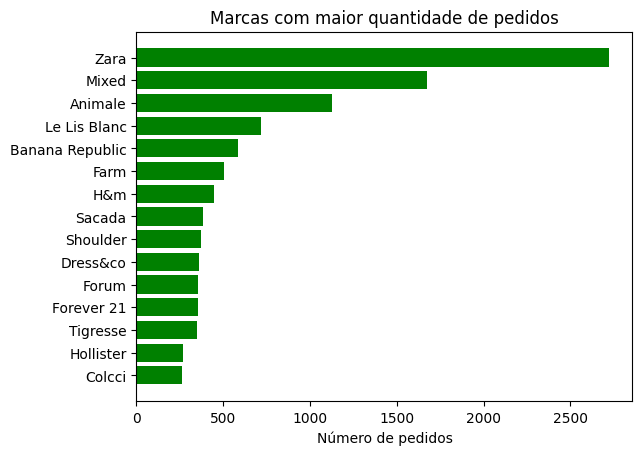

In [24]:
plt.barh(df_marcas['marca'][-15:], df_marcas['pedidos'][-15:], color='g')
plt.xlabel('Número de pedidos')
plt.title('Marcas com maior quantidade de pedidos')
plt.show()

# 3. Lidando com filtro

Vamos iniciar uma análise de desempenho do **time de vendedores** da Meteora. A intenção aqui é entender como se deram as vendas dos vendedores no **ano anterior** para que possam ser aplicadas promoções e bônus salarial para a equipe no ano atual da tabela que é 2021

In [27]:
sql_df('SELECT * FROM PEDIDOS').head(3)

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600


In [29]:
sql_df('SELECT * FROM PEDIDOS').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pedido_id    24527 non-null  int64 
 1   produto_id   24527 non-null  int64 
 2   vendedor_id  24527 non-null  int64 
 3   data_compra  24527 non-null  object
 4   total        24527 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 958.2+ KB


Para entender o desempenho de vendas dos vendedores no ano de 2020, é preciso trabalhar com os dados que estão presentes apenas no ano de 2020.

In [33]:
query = '''SELECT VENDEDOR_ID, COUNT(*)
FROM PEDIDOS
WHERE strftime('%Y', data_compra) = '2020'
GROUP BY VENDEDOR_ID
'''

sql_df(query)

,vendedor_id,COUNT(*)
0,1,3427
1,2,3338
2,3,2782
3,4,2510
4,5,2488


In [62]:
query = '''SELECT VENDEDORES.nome_vendedor, COUNT(PEDIDOS.produto_id) as 'Quantidade Vendas'
FROM PEDIDOS, VENDEDORES
WHERE strftime('%Y', data_compra) = '2020' AND VENDEDORES.vendedor_id = PEDIDOS.vendedor_id
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY COUNT(PEDIDOS.produto_id) DESC;
'''

sql_df(query)

,nome_vendedor,Quantidade Vendas
0,Ana Duarte,3427
1,Daniel Siqueira,3338
2,Nadia Oliveira,2782
3,Millena Pereira,2510
4,Paulo Calanca,2488


In [63]:
sql_df('SELECT * FROM PEDIDOS')

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575
...,...,...,...,...,...
24522,63716,64127,1,2021-03-09,2360
24523,63999,37384,2,2021-03-09,2800
24524,64594,100932,1,2021-03-10,19500
24525,64811,3820,3,2021-03-10,417


In [67]:
query = '''SELECT VENDEDORES.nome_vendedor, AVG(PEDIDOS.total) as 'Valor médio por Vendas'
FROM PEDIDOS, VENDEDORES
WHERE strftime('%Y', data_compra) = '2020' AND VENDEDORES.vendedor_id = PEDIDOS.vendedor_id
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY AVG(PEDIDOS.total) DESC;
'''

sql_df(query)

,nome_vendedor,Valor médio das Vendas
0,Daniel Siqueira,1972.338526
1,Millena Pereira,1894.614343
2,Ana Duarte,1843.452582
3,Nadia Oliveira,1818.342200
4,Paulo Calanca,1813.469855


Realizando a consulta com Built-functions

In [44]:
pedidos_2020 = pedidos[pedidos['data_compra'].str.startswith('2020')]

In [45]:
pedidos_2020.groupby('vendedor_id')['data_compra'].agg(['count'])

,count
vendedor_id,
1,3427
2,3338
3,2782
4,2510
5,2488


# 4. Avançando nas relações

A Meteora agora deseja incrementar as suas vendas no **estado de São Paulo (SP)**, por acreditar ser uma região mais propícia às vendas já que tem uma boa concentração de pessoas e mercado também.

Mas será que São Paulo já não rende muitas vendas em relação a outros estados?

In [72]:
query = '''SELECT ESTADO, COUNT(*) AS pedidos
FROM ITENS_PEDIDOS
GROUP BY ESTADO
ORDER BY COUNT(*) DESC'''

sql_df(query)

,Estado,pedidos
0,BR-MA,974
1,BR-DF,953
2,BR-MT,937
3,BR-GO,933
4,BR-PA,932
5,BR-AL,928
6,BR-PE,927
7,BR-RR,925
8,BR-RO,925
9,BR-RN,921


Uma das ações que a Meteora pretende seguir para as vendas em SP é escolher dois de seus vendedores para que eles **foquem suas vendas** lá. Para essa escolha é interessante ter os profissionais que **mais tenham vendido** para as pessoas da região.

In [81]:
query = '''SELECT VENDEDORES.NOME_VENDEDOR, COUNT(*) as 'quantidade_vendas'
FROM PEDIDOS
JOIN VENDEDORES ON VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PEDIDO_ID = PEDIDOS.PEDIDO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY quantidade_vendas DESC'''

sql_df(query)

,nome_vendedor,quantidade_vendas
0,Daniel Siqueira,190
1,Paulo Calanca,182
2,Nadia Oliveira,181
3,Ana Duarte,180
4,Millena Pereira,157
